# Imports:

In [49]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Discrete Data + Probability

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

# Acquire:

In [50]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8])



In [51]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [52]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [53]:
#data types mainly object, timestamp needs to be altered.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [54]:
df.shape

(13978, 7)

------

# Prepare:

In [55]:
# change timestamp to datetime which excludes brackets and +0000
#have to make time stamp a string in order to remove this excessive text.
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex =True)

In [56]:
df.head(1)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [57]:
#change timestamp datatype to datetime 
# the 1 within the .replace is directing the
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

#set dattime to index
df = df.set_index('timestamp').sort_index()

In [58]:
#created new column where converted bytes to MB so bytes/1024**2
df['size_mb'] = df['size']/1024**2
#dropping bytes column
df.drop(columns = 'size', inplace =True)

In [59]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.488753
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.003396
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.486472
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.486377
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.488246


In [60]:
#will focus on status since 499 and 301 appear unique.
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [61]:
def unique_count(df):
    for col in df.columns:
        print(df[col].value_counts())

In [62]:
unique_count(df)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
35.175.171.137        2
70.121.214.34         2
52.87.230.102         2
34.207.64.242         1
54.145.52.184         1
35.174.209.2          1
97.105.15.120         1
3.92.201.136          1
52.91.30.150          1
95.31.16.121          1
3.88.129.158          1
54.172.14.223         1
52.90.165.200         1
34.229.70.250         1
45.23.250.16          1
95.31.18.119          1
Name: ip, dtype: int64
"GET /api/v1/sales?page=2 HTTP/1.1"       709
"GET /api/v1/items HTTP/1.1"              464
"GET /api/v1/items?page=2 HTTP/1.1"       291
"GET /api/v1/items?page=3 HTTP/1.1"       219
"GET /api/v1/stores HTTP/1.1"             162
                                         ... 
GET /api/v1/items/HTTP/1.1                  1
"GET /api/V1/HiZach! HTTP/1.1"              1
"GET /api/v1//api/v1/items HTTP/1.1"        1
"GET /api/v1/items&page=0 HTTP/1.1"

In [63]:
# get the counts of status in the dataset
#how many times the value of a particular value shows up in the data.
# once we know count, can figure prob = count/total
status_df = pd.DataFrame(df.status.value_counts().reset_index().rename(columns = {'index': 'status', 'status': 'status_count'}))
status_df

,status,status_count
0,200,13960
1,499,16
2,301,2


In [64]:
status_df.value_counts()

status  status_count
499     16              1
301     2               1
200     13960           1
dtype: int64

In [65]:
# need to calculate the probability of each status
#probability is the number over the total so take each unique status total count and divide by count of entrie status field count.
status_df2 = pd.DataFrame(df.status.value_counts(dropna =False)/df.status.count()).reset_index().rename(columns = {'index':'status', 'status':'status_prob'})
status_df2

,status,status_prob
0,200,0.998712
1,499,0.001145
2,301,0.000143


In [66]:
#now want to merge these to the original status df
status_df = status_df.merge(status_df2)
status_df.head()

,status,status_count,status_prob
0,200,13960,0.998712
1,499,16,0.001145
2,301,2,0.000143


In [67]:
stats = pd.DataFrame(status_df['status_prob'].value_counts())
stats.reset_index()
stats.index *100

Float64Index([0.014308198597796537, 99.87122621261983, 0.1144655887823723], dtype='float64')

In [75]:
status_df[status_df.status_prob < .02]

,status,status_count,status_prob
1,499,16,0.001145
2,301,2,0.000143


In [86]:
#creating data frame which gives the value_count of each ip(pb)
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [87]:
ip_df

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,35.175.171.137,2
7,70.121.214.34,2
8,52.87.230.102,2
9,34.207.64.242,1


In [88]:
#need to calculate the probability
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502


## 

In [89]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2)


# look at rows where ip_proba is less than 0.01
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,34.207.64.242,1,0.000072
10,54.145.52.184,1,0.000072
11,35.174.209.2,1,0.000072
12,97.105.15.120,1,0.000072
13,3.92.201.136,1,0.000072


In [90]:
#plot the ip_count

def plot_unique(df,col1, col2):
    plt.figure(figsize=(12, 4))
    splot = sns.barplot(data=ip_df, x = col1, y = col2, ci = None)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 10), 
                       textcoords = 'offset points'
                       )
        plt.xticks(rotation='vertical')

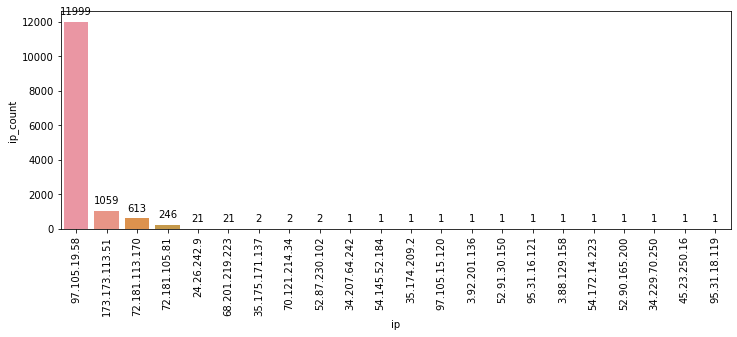

In [93]:
plot_unique(ip_df, ip_df.ip, ip_df.ip_count)

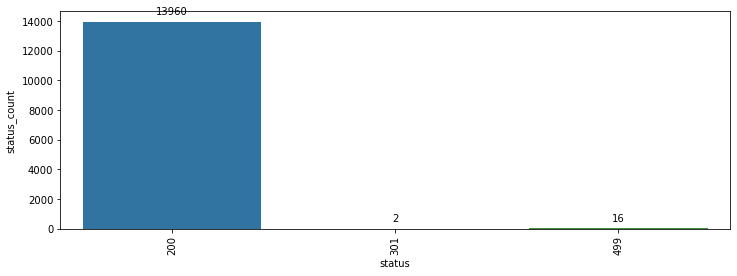

In [94]:
plot_unique(status_df, status_df.status, status_df.status_count)

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.


#### Establish Baseline: